# Data Pipeline
Initial data analysis pipeline including a naive sentiment analysis using TextBlob.

In [1]:
import re
import html
import spacy
import textacy
from textblob import TextBlob
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
import calmap # for making GitHub-style calendar plots of time-series
import matplotlib.pyplot as plt
# Plot using Pandas datatime objects
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
rc_fonts = {'figure.figsize': (15, 8),
            'axes.labelsize': 20,
            'xtick.labelsize': 16,
            'ytick.labelsize': 16}
plt.rcParams.update(rc_fonts)
plt.style.use('ggplot')
%matplotlib inline

In [3]:
from string import punctuation

## Use ```spaCy``` for tokenization and sentence segmentation

In [4]:
import spacy
from spacy import displacy
# Load spaCy language model (blank model to which we add pipeline components)
sentencizer = spacy.blank('en')
sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))

#### Specify named entity of interest

In [5]:
name = "Ryan Lochte"

In [6]:
datafile = 'all_the_news_v2.csv'
datapath = Path('../') / 'data' / datafile 
colnames = ['title', 'author', 'date', 'content', 'year', 'month', 'publication', 'length']

news = pd.read_csv(datapath, usecols=colnames, parse_dates=['date'])
news['author'] = news['author'].str.strip()
news.head()

,title,author,date,content,year,month,publication,length
0,Agent Cooper in Twin Peaks is the audience: on...,Tasha Robinson,2017-05-31,And never more so than in Showtime’s new...,2017.0,5.0,Verge,2376
1,"AI, the humanity!",Sam Byford,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,2017.0,5.0,Verge,2125
2,The Viral Machine,Kaitlyn Tiffany,2017-05-25,Super Deluxe built a weird internet empi...,2017.0,5.0,Verge,3310
3,How Anker is beating Apple and Samsung at thei...,Nick Statt,2017-05-22,Steven Yang quit his job at Google in th...,2017.0,5.0,Verge,3632
4,Tour Black Panther’s reimagined homeland with ...,Kwame Opam,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,2017.0,5.0,Verge,262


In [7]:
news = news.dropna(subset=['date', 'title'])
news.shape[0]

143156

In [8]:
news['date'].describe()

count                  143156
unique                   1480
top       2017-01-13 00:00:00
freq                      415
first     2000-05-15 00:00:00
last      2017-07-05 00:00:00
Name: date, dtype: object

### Filter articles based on name match
In this section we only select those news articles that contain part of or all of the name we input as ```name```.

In [9]:
def check_name(content, name):
    flag = False
    if name in content:
        flag = True
    return flag

def filter_df(df):
    df['match'] = df['content'].apply(lambda x: check_name(x, name))
    df_relevant = df.loc[df['match'].eq(True)]
    return df_relevant.drop(['match'], axis=1)

news_relevant = filter_df(news)
print(news_relevant.shape[0])
news_relevant.head()

182


,title,author,date,content,year,month,publication,length
3095,"After Olympic-sized goof, Ryan Lochte begins a...",David Wharton,2017-04-27,Don’t cringe or shake your head or stop readin...,2017.0,4.0,Los Angeles Times,1925
8946,Michael Phelps is a touch off in 100 butterfly...,Everett Cook,2014-08-08,Michael Phelps\' bid for his most important wi...,2014.0,8.0,Los Angeles Times,996
13789,Michael Phelps Powers U.S. to Victory in 4x100...,"Victor Mather, Karen Crouse and Doug Mills",2016-08-10,RIO DE JANEIRO — Michael Phelps won his 19th O...,2016.0,8.0,New York Times,276
13825,Rio Olympics: Simone Manuel Makes History in t...,Karen Crouse,2016-08-16,RIO DE JANEIRO — Simone Manuel managed to make...,2016.0,8.0,New York Times,1468
13839,"Rio Olympics: A Phelps Upset, a Judo Snub, and...",Sam Manchester and Victor Mather,2016-08-16,Katie Ledecky did what Katie Ledecky does best...,2016.0,8.0,New York Times,1614


### Perform sentence segmentation
Store the sentences in each news articles as a list of sentences, from which we can easily extract per-sentence sentiment.

In [10]:
def get_relevant(text, name):
    doc = sentencizer(text)
    relevant = []
    for sent in doc.sents:
        for n in name.split():
            if n in sent.text:
                clean = sent.text.replace("\n", " ").replace("\xa0", " ")
                # Strip bad characters at the start of sentences
                clean = clean.strip("[\'").strip("\']").strip('\"').strip("\'\"")
                clean = clean.strip(",\'").strip("\',").strip('\"').strip("\'\"").strip()
                relevant.append(clean)
    # Remove duplicates
    relevant = list(dict.fromkeys(relevant))
    return relevant

In [11]:
news_relevant['relevant'] = news_relevant['content'].apply(lambda x: get_relevant(x, name))

In [12]:
for i in news_relevant['relevant'][:5]:
    print(i, '\n--')

["That’s all Ryan Lochte wants as he ambles across the pool deck on a bright Southern California day, looking tanned and relaxed, if a bit weary from his morning workout.', '“", 'Lochte now finds himself living in Los Angeles with his pregnant fiancée and training at USC with thoughts of a comeback.', "Here’s the condensed version:', 'After a fifth-place finish in the 200-meter individual medley — his dissatisfaction hardly assuaged by a gold in the 800 freestyle relay — Lochte partied with three teammates at the French team’s hospitality house.',", "Lochte initially told authorities they were pulled over and robbed by armed men posing as police officers.',", "Lochte suffered an additional blow as Speedo and other corporate sponsors walked away.',", 'Ryan Lochte didn’t have to get drunk and vandalize a Rio de Janeiro gas station during the Summer Olympics in August.', "But he did, and it’s at times like this when people really need their...', 'Ryan Lochte didn’t have to get drunk and v

### Sentiment scoring using FastText

In [13]:
import fastText
# Load trained fastText model
model_path = './fasttext_models/yelp_full/reviews_model_ngrams.bin'

#### Preprocess text and tokenize as per FastText requirements

In [14]:
def fasttext_tokenize(string):
    string = string.lower()
    string = re.sub(r"([.!?,'/()])", r" \1 ", string)
    return string

In [15]:
# reviews = [
#     "This restaurant literally changed my life. This is the best food I've ever eaten!",
#     "I hate this place so much. They were mean to me.",
#     "I don't know. It was ok, I guess. Not really sure what to say.",
# ]

# preprocessed_reviews = list(map(strip_formatting, reviews))
# # Load classifier
# classifier = fastText.load_model(model_path)

# # Get fastText to classify each review with the model
# labels, probabilities = classifier.predict(preprocessed_reviews, 1)
# stars = [int(l[0][-1]) - 3 for l in labels]
# stars

In [16]:
classifier = fastText.load_model(model_path)
def get_score_fasttext(text_list):
    # Calculate polarity for each sentence
    preprocessed = list(map(fasttext_tokenize, text_list))
    labels, probabilities = classifier.predict(preprocessed, 1)
    sentiment_list = [(int(l[0][-1]) - 3)/2 for l in labels if l]
    score = np.mean(sentiment_list)
    deviation = np.std(sentiment_list)
    return score, deviation

In [17]:
news_relevant['score'], news_relevant['deviation'] = zip(*news_relevant['relevant'].map(get_score_fasttext))
news_relevant.head(5)

,title,author,date,content,year,month,publication,length,relevant,score,deviation
3095,"After Olympic-sized goof, Ryan Lochte begins a...",David Wharton,2017-04-27,Don’t cringe or shake your head or stop readin...,2017.0,4.0,Los Angeles Times,1925,[That’s all Ryan Lochte wants as he ambles acr...,-0.236842,0.848659
8946,Michael Phelps is a touch off in 100 butterfly...,Everett Cook,2014-08-08,Michael Phelps\' bid for his most important wi...,2014.0,8.0,Los Angeles Times,996,"[Ryan Lochte, another preeminent American swim...",1.000000,0.000000
13789,Michael Phelps Powers U.S. to Victory in 4x100...,"Victor Mather, Karen Crouse and Doug Mills",2016-08-10,RIO DE JANEIRO — Michael Phelps won his 19th O...,2016.0,8.0,New York Times,276,[Ryan Held and Nathan Adrian brought the U.S. ...,1.000000,0.000000
13825,Rio Olympics: Simone Manuel Makes History in t...,Karen Crouse,2016-08-16,RIO DE JANEIRO — Simone Manuel managed to make...,2016.0,8.0,New York Times,1468,[Michael Phelps won the 200 individual medley ...,0.750000,0.250000
13839,"Rio Olympics: A Phelps Upset, a Judo Snub, and...",Sam Manchester and Victor Mather,2016-08-16,Katie Ledecky did what Katie Ledecky does best...,2016.0,8.0,New York Times,1614,[Phelps Breaks an Ancient Record: Michael Phel...,0.750000,0.250000


### Lemmatize relevant sentences for comparison
This is to remove duplicates.

In [18]:
# Load full spaCy language model for upcoming NLP pipeline
nlp = spacy.load('en_core_web_md')

In [19]:
add_removed_words = {n.lower() for n in name.split()}
# Include specific words to be removed
stopwords = nlp.Defaults.stop_words
stopwords = stopwords.union(add_removed_words)

In [20]:
# Tokenize and lemmatize text
def lemmatize(text):
    doc = sentencizer(text)
    tokens = [str(tok.lemma_).lower() for tok in doc if tok.text not in stopwords \
              and tok.text not in punctuation]
    return tokens

In [21]:
news_relevant['lemmas'] = news_relevant['relevant'].str.join(' ').apply(lemmatize).str.join(' ')
news_relevant[['relevant', 'lemmas']].head()

,relevant,lemmas
3095,[That’s all Ryan Lochte wants as he ambles acr...,that ’s ryan lochte want amble pool deck brigh...
8946,"[Ryan Lochte, another preeminent American swim...",ryan lochte preeminent american swimmer finish...
13789,[Ryan Held and Nathan Adrian brought the U.S. ...,ryan held nathan adrian bring u.s. home adrian...
13825,[Michael Phelps won the 200 individual medley ...,michael phelps win 200 individual medley easil...
13839,[Phelps Breaks an Ancient Record: Michael Phel...,phelps breaks ancient record michael phelps wi...


### Drop duplicates

In [22]:
news_relevant = news_relevant.drop_duplicates(subset=['lemmas'])
news_relevant.shape[0]

161

#### Positive sentiment group

In [23]:
pos = news_relevant[news_relevant['score'] > 0.0].sort_values(by=['score'], ascending=False).reset_index(drop=True)
print("Found {} overall positive articles for {}".format(pos.shape[0], name))
pos.head(3)

Found 60 overall positive articles for Ryan Lochte


,title,author,date,content,year,month,publication,length,relevant,score,deviation,lemmas
0,Michael Phelps is a touch off in 100 butterfly...,Everett Cook,2014-08-08,Michael Phelps\' bid for his most important wi...,2014.0,8.0,Los Angeles Times,996,"[Ryan Lochte, another preeminent American swim...",1.0,0.0,ryan lochte preeminent american swimmer finish...
1,The Rio Olympics: A Crib Sheet,The Editors,2016-08-11,[ For us to continue writing great stor...,2016.0,8.0,Atlantic,863,"[We’re also watching America’s Ryan Lochte, So...",1.0,0.0,-pron- be watch america ’s ryan lochte south a...
2,Frank Ocean and Chance the Rapper: The Week i...,The Editors,2016-08-27,[The main site for Archive Team is at archivet...,2016.0,8.0,Atlantic,1254,[Michelangelo's David and Ryan Lochte: The Wee...,1.0,0.0,michelangelo have david ryan lochte the week p...


#### Write positive results

In [24]:
out_filename = '_'.join(name.split()).lower() + '_pos.csv'
out_path = Path('./') / "results/fasttext" / out_filename
pos.sort_values(by='publication')[['publication', 'title', 'date', 'relevant', 'score', 'deviation']] \
                .to_csv(out_path, index=False, header=True)

#### Negative sentiment group

In [25]:
neg = news_relevant[news_relevant['score'] < 0.0].sort_values(by=['score']).reset_index(drop=True)
print("Found {} overall negative articles for {}".format(neg.shape[0], name))
neg.head(3)

Found 83 overall negative articles for Ryan Lochte


,title,author,date,content,year,month,publication,length,relevant,score,deviation,lemmas
0,The Continuing Saga of the U.S. Swimmers in Rio,Krishnadev Calamur,2016-08-18,"[Updated on August 18 at 11:46 a.m. ET, Brazil...",2016.0,8.0,Atlantic,538,[Three of the four swimmers involved in the in...,-1.0,0.0,three swimmer involve incident rio 4 ryan loch...
1,Swimmers who were allegedly robbed with Ryan L...,Emmett Knowlton,2016-08-18,"['\n\n', '\n American Olympians\xa0Gunnar Ben...",2016.0,8.0,Business Insider,421,"[\n\n', '\n American Olympians\xa0Gunnar Bent...",-1.0,0.0,\n\n \n american olympians\xa0gunnar bentz j...
2,NBC's Matt Lauer says Ryan Lochte changed his ...,Cork Gaines,2016-08-18,"['\n\n', ""\n On Wednesday night, NBC's Matt L...",2016.0,8.0,Business Insider,334,"[\n\n', ""\n On Wednesday night, NBC's Matt La...",-1.0,0.0,\n\n \n on wednesday night nbc have matt lau...


In [26]:
neg['relevant'][2][0]

'\\n\\n\', "\\n  On Wednesday night, NBC\'s Matt Lauer reported that he had spoken\\n  to American swimmer Ryan Lochte about being robbed at gunpoint on\\n  the way back to the Olympic village this past weekend and\\n  according to Lauer, some key details have changed.\\n", \'\\n  In an exchange with Bob Costas, Lauer was asked if Lochte\\n  "altered any of the details.'

#### Write negative results

In [27]:
out_filename = '_'.join(name.split()).lower() + '_neg.csv'
out_path = Path('./') / "results/fasttext" / out_filename
neg.sort_values(by='publication')[['publication', 'title', 'date', 'relevant', 'score', 'deviation']] \
                .to_csv(out_path, index=False, header=True)

In [28]:
mixed = news_relevant[news_relevant['score'] == 0.0].reset_index(drop=True)
print("Found {} overall mixed articles for {}".format(mixed.shape[0], name))
mixed.head(3)

Found 18 overall mixed articles for Ryan Lochte


,title,author,date,content,year,month,publication,length,relevant,score,deviation,lemmas
0,Rio ‘Has Never Felt So Safe.’ But What Happens...,Simon Romero and Andrew Jacobs,2016-08-22,RIO DE JANEIRO — Portugal’s education minister...,2016.0,8.0,New York Times,1256,[Even before the armed robbery this weekend of...,0.0,1.0,even arm robbery weekend american swimmer incl...
1,"At the Olympics, the Thrill of Victory, the Ag...",Christopher Clarey,2017-02-01,"RIO DE JANEIRO — It was 1:30 a.m. Saturday, an...",2017.0,2.0,New York Times,1598,"[RIO DE JANEIRO — It was 1:30 a.m. Saturday, a...",0.0,1.0,rio de janeiro -- it 1:30 a.m. saturday mathie...
2,"Zika, U.S. Presidential Race, Ryan Lochte: You...",Andrea Kannapell and Sandra Stevenson,2016-08-22,(Want to get this briefing by email? Here’s th...,2016.0,8.0,New York Times,940,[I want to apologize for my behavior last week...,0.0,0.0,i want apologize behavior weekend -- careful c...


### Highlight relevant named entities using ```spaCy```

In [29]:
from IPython.display import Markdown, display
options = {'ents': ['PERSON', 'ORG', 'GPE', 'EVENT'], 
           'colors': {'PERSON': '#9fafe5', 'ORG': '#d59b9b', 'GPE':'#81cba6'}}
def printmd(string):
    display(Markdown(string))
    
def display_entities(df, max_entries=5):
    # Set relevant named entities that we want to extract
    for idx, sent in enumerate(df['relevant'].str.join(' ')[:max_entries]):
        doc = nlp(sent)
        printmd('**{}**'.format(df['title'][idx]))
        displacy.render(doc, style='ent', jupyter=True, options=options)
        print('\n')
        
def vis(pos, neg, mixed):
    # Visualize positive and negativ groups using markdown
    printmd('<font color=green>**Positive**</font>')
    display_entities(pos)
    printmd('<font color=red>**Negative**</font>')
    display_entities(neg)
    printmd('<font color=yellow>**Mixed**</font>')
    display_entities(mixed)

In [30]:
vis(pos, neg, mixed)

<font color=green>**Positive**</font>

**Michael Phelps is a touch off in 100 butterfly at U.S. swim nationals - LA Times**

**The Rio Olympics: A Crib Sheet**

** Frank Ocean and Chance the Rapper: The Week in Pop-Culture Writing**

**Michael Phelps Powers U.S. to Victory in 4x100 Relay, Winning a 19th Gold - The New York Times**

**Mel Gibson Is Not Sorry**

<font color=red>**Negative**</font>

**The Continuing Saga of the U.S. Swimmers in Rio**

**Swimmers who were allegedly robbed with Ryan Lochte were reportedly stopped from leaving Rio**

**NBC's Matt Lauer says Ryan Lochte changed his Rio robbery story on two key details**

**Kanye West fan tries to climb floating stage at Atlanta concert**

**Far From Olympics, Violence Rises In Rio's Poorest Neighborhoods**

<font color=yellow>**Mixed**</font>

**Rio ‘Has Never Felt So Safe.’ But What Happens After the Games? - The New York Times**

**At the Olympics, the Thrill of Victory, the Agony of Defeat and the Lure of the Dance Floor - The New York Times**

**Zika, U.S. Presidential Race, Ryan Lochte: Your Friday Evening Briefing - The New York Times**

**U.S. Presidential Race, Ryan Lochte, Rio de Janeiro: Your Monday Evening Briefing - The New York Times**

**Matt Lauer Loses the War in a Battle Between the Candidates - The New York Times**

## Visualization

### Plot sentiment score and magnitude versus time of publishing of the article
In this section, sentiment "score" is the median of all polarity values (positive or negative) obtained per-sentence of the article from TextBlob. Sentiment "magnitude" is the standard deviation of sentiment among the per-sentence polarity values. 

In [31]:
news_avg_score = news_relevant.groupby('date')['score'].mean()
news_avg_dev = news_relevant.groupby('date')['deviation'].mean()

#### Concatenate scores and magnitudes for plotting

In [32]:
scores = pd.concat((news_avg_score, news_avg_dev), axis=1).sort_values(by=['date'])
scores.head()

,score,deviation
date,,
2014-08-08,1.000000,0.000000
2016-06-27,0.222222,0.931281
2016-08-05,0.500000,0.000000
2016-08-06,0.000000,0.000000
2016-08-07,-1.000000,0.000000


#### Reindex data to show daily scores
Since we have really sparse data (news articles about the target are not written every day, we reindex the time series and fill missing values with zeros. 

In [33]:
idx = pd.date_range('1/1/2014', '7/5/2017')
scores_daily = scores.reindex(idx, fill_value=0.0)

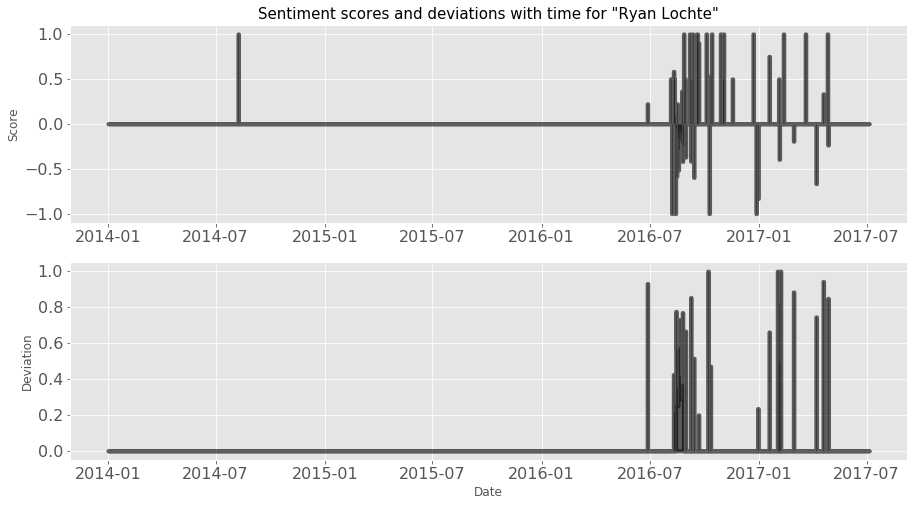

In [34]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
ax1.fill_between(scores_daily.index, scores_daily['score'], step='mid', color='black', alpha=0.6, linewidth=4);
ax1.set_ylabel('Score');
ax1.set_title('Sentiment scores and deviations with time for "{}"'.format(name), size=15);
ax2.fill_between(scores_daily.index, scores_daily['deviation'], step='mid', color='black', alpha=0.6, linewidth=4);
ax2.set_ylabel('Deviation');
ax2.set_xlabel('Date');
# plt.savefig("{}_scores".format('_'.join(name.split()).lower()))

#### Make calendar plot to show periods of activity

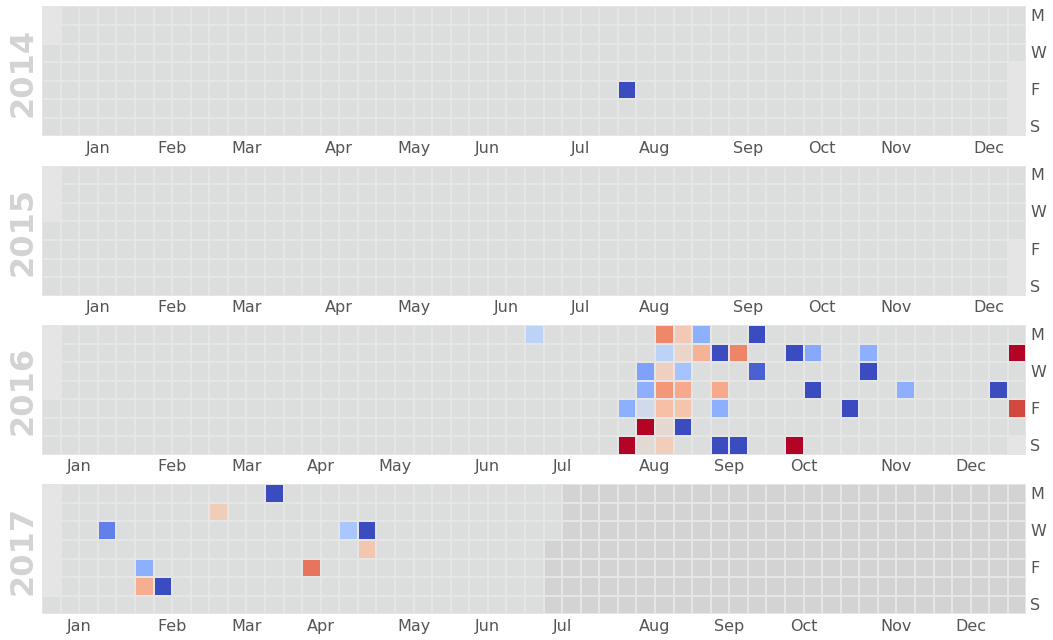

In [39]:
calmap.calendarplot(scores_daily['score'],
                    vmin = -1.0,
                    vmax=1.0,
                    daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6],
                    fig_kws=dict(figsize=(15, 9)),
                    linewidth=1,
                    fillcolor='lightgrey',
                    cmap='coolwarm_r',
                   );

#### Get counts of positive and negative mentions based on Publication

In [36]:
grouped = news_relevant.groupby('publication').apply(lambda x: x['score'] >= 0.0)
grouped = grouped.groupby('publication').value_counts().to_frame()
grouped = grouped.unstack().fillna(0.0)
grouped.columns = ['Negative', 'Positive']
grouped = grouped.sort_values(by='Negative')
grouped

,Negative,Positive
publication,,
Los Angeles Times,1,1
National Review,2,5
Guardian,3,11
New York Post,3,9
Reuters,3,1
Business Insider,4,2
Breitbart,6,1
Fox News,7,5
Buzzfeed News,9,2


#### Plot article breakdown

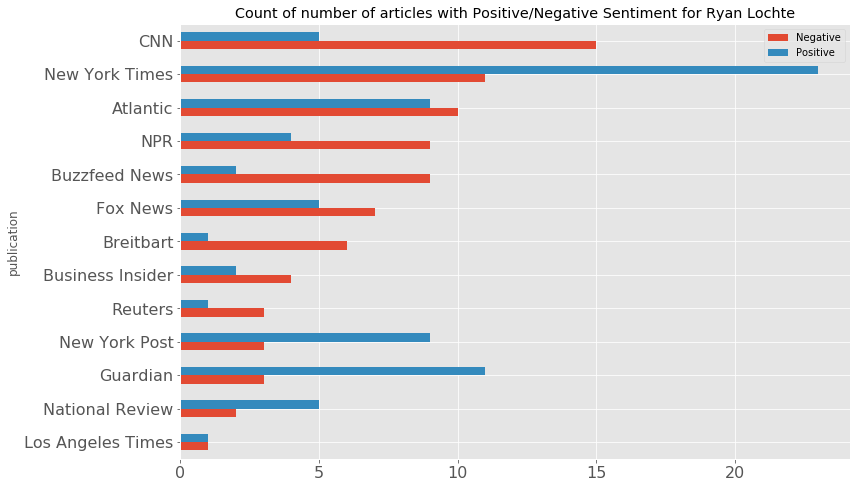

In [37]:
grouped.plot(kind='barh', figsize=(12, 8));
plt.title('Count of number of articles with Positive/Negative Sentiment for {}'.format(name));
# plt.savefig("{}_breakdown".format('_'.join(name.split()).lower()))

#### Output result to CSV

In [38]:
out_filename = '_'.join(name.split()).lower() + '_breakdown.csv'
out_path = Path('./') / "results/fasttext" / out_filename
grouped.to_csv(out_path, index=False, header=True)